In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
from random import sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller,acf
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [57]:
funnel=pd.read_excel("Intern Hiring Assignment Data.xlsx",sheet_name="Funnel")
funnel

,Year,Month,Customer Segment,Region,KPI,Value Type,Value
0,2020,12,Clients,India,Lv1_Visitors,Actuals,1354648.00
1,2020,12,Clients,India,Lv2_Visitors,Actuals,2689569.00
2,2020,12,Clients,India,Lv3_Visitors,Actuals,1300571.00
3,2020,12,Clients,India,Lv4_Visitors,Actuals,NaN
4,2020,12,Clients,India,Lv3_Visitors,Actuals,706677.00
...,...,...,...,...,...,...,...
1567,2022,1,Customers,Dehradun,Lv5_Visitors,Actuals,1693.00
1568,2022,1,Customers,Aurangabad,Lv4_Visitors,Actuals,1428.00
1569,2022,1,Customers,Ujjain,Lv5_Visitors,Actuals,1311.00
1570,2022,1,Customers,Faridabad,Lv5_Visitors,Actuals,1071.00


In [58]:
abtest=pd.read_excel("Intern Hiring Assignment Data.xlsx",sheet_name="ABTest")
abtest

,Months (Date),Date,Variants,DeviceType,Sum of Clicks,Sum of Visitors
0,Mar,2023-03-29,Control,Desktop,31312,298032
1,Mar,2023-03-29,Control,Mobile,18399,192144
2,Mar,2023-03-29,Control,Others,34,375
3,Mar,2023-03-29,Control,Tablet,660,7646
4,Mar,2023-03-29,Treatment,Desktop,10067,32737
...,...,...,...,...,...,...
139,Apr,2023-04-15,Control,Tablet,676,6638
140,Apr,2023-04-15,Treatment,Desktop,5260,21292
141,Apr,2023-04-15,Treatment,Mobile,2958,19269
142,Apr,2023-04-15,Treatment,Others,3,37


In [59]:
funnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              1572 non-null   int64  
 1   Month             1572 non-null   int64  
 2   Customer Segment  1572 non-null   object 
 3   Region            1572 non-null   object 
 4   KPI               1572 non-null   object 
 5   Value Type        1572 non-null   object 
 6   Value             1547 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 86.1+ KB


In [60]:
funnel.value_counts()

Year  Month  Customer Segment  Region     KPI           Value Type  Value     
2020  1      Clients           India      Lv1_Visitors  Actuals     3322789.00    1
2022  4      Clients           Indore     Lv2_Visitors  Actuals     63090.00      1
      3      Customers         India      Lv1_Visitors  Actuals     578083.00     1
                               Faridabad  Lv5_Visitors  Actuals     1524.00       1
                                          Lv4_Visitors  Actuals     5967.00       1
                                                                                 ..
2021  2      Customers         Uddepy     Lv4_Visitors  Actuals     42753.00      1
                                          Lv3_Visitors  Actuals     88016.00      1
                                          Lv2_Visitors  Actuals     87365.00      1
                                          Lv1_Visitors  Actuals     114704.00     1
2022  12     Customers         Ujjain     Lv5_Visitors  Actuals     293.00       

In [61]:
funnel.drop(columns=["Value Type"],inplace=True)

In [62]:
pd.options.display.float_format = '{:.2f}'.format

,Year,Month,Customer Segment,Region,KPI,Value
Year,1.00,-0.00,-0.23,0.09,-0.02,-0.05
Month,-0.00,1.00,0.00,0.00,0.00,-0.02
Customer Segment,-0.23,0.00,1.00,-0.16,-0.05,-0.59
Region,0.09,0.00,-0.16,1.00,-0.00,0.26
KPI,-0.02,0.00,-0.05,-0.00,1.00,-0.36
Value,-0.05,-0.02,-0.59,0.26,-0.36,1.00


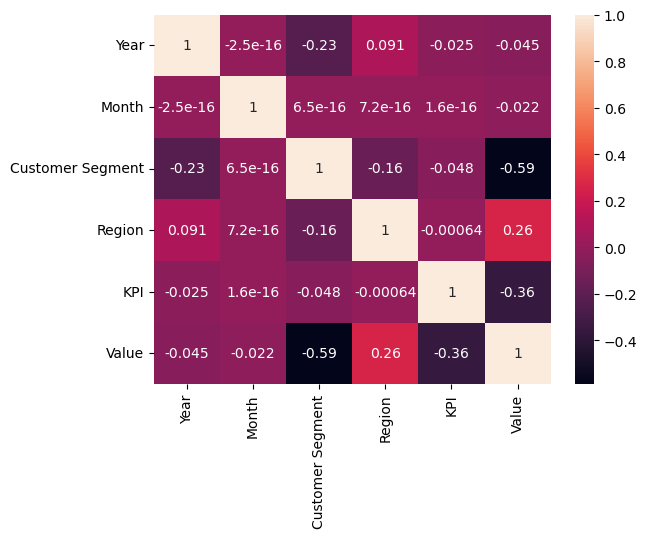

In [63]:
# Create a copy of the DataFrame
df_encoded = funnel.copy()

# Apply LabelEncoder to each column
for column in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])

# Now you can create your heatmap
sns.heatmap(df_encoded.corr(), annot=True)
df_encoded.corr()

In [64]:
for kpi in funnel['KPI'].unique():
    mean = funnel[funnel['KPI'] == kpi]['Value'].mean()
    median = funnel[funnel['KPI'] == kpi]['Value'].median()
    print(f"For KPI {kpi}, Mean: {mean}, Median: {median}")

For KPI Lv1_Visitors, Mean: 544273.1833333333, Median: 78694.5
For KPI Lv2_Visitors, Mean: 367219.31740614335, Median: 51787.0
For KPI Lv3_Visitors, Mean: 285153.8264984227, Median: 50636.0
For KPI Lv4_Visitors, Mean: 127959.91693290735, Median: 26418.0
For KPI Lv5_Visitors, Mean: 43758.41358024691, Median: 7757.0


In [65]:
# train_data = funnel[funnel['Value'].notnull()]
# predict_data = funnel[funnel['Value'].isnull()]

# X_train, X_val, y_train, y_val = train_test_split(train_data.drop('Value', axis=1), 
#                                                   train_data['Value'], 
#                                                   test_size=0.2, 
#                                                   random_state=42)

# train_pool = Pool(data=X_train, label=y_train, cat_features=["Customer Segment","Region","Value Type"])
# val_pool = Pool(data=X_val, label=y_val, cat_features=["Customer Segment","Region","Value Type"])

# model = CatBoostRegressor()

# grid = {'iterations': [100, 200, 300],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'depth': [4, 6, 8],
#         'l2_leaf_reg': [1, 3, 5]}

# result = model.grid_search(grid, train_pool, plot=True, verbose=False)

# print(result['params'])
# print(min(result['cv_results']['test-RMSE-mean']))

In [66]:
# Split the data
train_data = funnel[funnel['Value'].notnull()]
predict_data = funnel[funnel['Value'].isnull()]

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data.drop('Value', axis=1), 
                                                  train_data['Value'], 
                                                  test_size=0.2, 
                                                  random_state=42)

# Create Pool objects for train and validation sets
train_pool = Pool(data=X_train, label=y_train, cat_features=["Customer Segment","Region","KPI"])
val_pool = Pool(data=X_val, label=y_val, cat_features=["Customer Segment","Region","KPI"])

#Best Params
best_params={'depth': 8, 'l2_leaf_reg': 5, 'iterations': 300, 'learning_rate': 0.1}

# Initialize the model
model = CatBoostRegressor(**best_params)

# Fit the model with the best parameters
model.fit(train_pool)

# Predict the missing values
predict_data['Value'] = model.predict(predict_data.drop('Value', axis=1))

0:	learn: 607201.6507201	total: 50.7ms	remaining: 15.2s
1:	learn: 559407.5398470	total: 102ms	remaining: 15.2s
2:	learn: 519131.7736102	total: 146ms	remaining: 14.5s
3:	learn: 483532.6377257	total: 175ms	remaining: 13s
4:	learn: 450360.0178963	total: 224ms	remaining: 13.2s
5:	learn: 421451.5644023	total: 298ms	remaining: 14.6s
6:	learn: 391337.2023592	total: 340ms	remaining: 14.2s
7:	learn: 367184.6024983	total: 384ms	remaining: 14s
8:	learn: 345752.3479016	total: 427ms	remaining: 13.8s
9:	learn: 326454.8684137	total: 485ms	remaining: 14.1s
10:	learn: 309840.8235394	total: 536ms	remaining: 14.1s
11:	learn: 297014.9029578	total: 595ms	remaining: 14.3s
12:	learn: 285187.8675464	total: 629ms	remaining: 13.9s
13:	learn: 272066.1861449	total: 682ms	remaining: 13.9s
14:	learn: 259879.4224362	total: 739ms	remaining: 14s
15:	learn: 251517.4214355	total: 800ms	remaining: 14.2s
16:	learn: 244300.2390128	total: 864ms	remaining: 14.4s
17:	learn: 235052.6695535	total: 922ms	remaining: 14.4s
18:	lea

In [67]:
complete_data = pd.concat([train_data, predict_data])

In [68]:
complete_data[funnel["Value"].isna()]

,Year,Month,Customer Segment,Region,KPI,Value
3,2020,12,Clients,India,Lv4_Visitors,338507.36
132,2021,9,Clients,India,Lv2_Visitors,1962548.23
133,2021,9,Clients,India,Lv3_Visitors,727877.66
166,2020,8,Clients,India,Lv3_Visitors,1194743.70
175,2021,8,Clients,India,Lv4_Visitors,380910.45
257,2021,6,Clients,India,Lv3_Visitors,732035.57
331,2020,4,Clients,India,Lv4_Visitors,661626.45
381,2021,3,Clients,India,Lv3_Visitors,998898.51
454,2020,1,Clients,India,Lv3_Visitors,1287166.79
463,2021,1,Clients,India,Lv3_Visitors,1269541.75


In [69]:
complete_data["Value"].std(),funnel["Value"].std()

(643190.3088432373, 644440.5529114249)

In [70]:
complete_data["Value"].mean(),funnel["Value"].mean()

(271595.57419569744, 268584.4589528119)

In [71]:
complete_data.shape,funnel.shape

((1572, 6), (1572, 6))

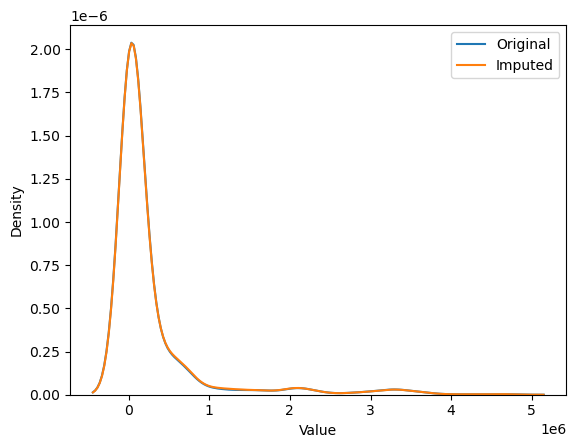

In [72]:
# Plot the KDE of 'Value' in the original data
sns.kdeplot(funnel['Value'], label='Original')
# Plot the KDE of 'Value' in the complete data
sns.kdeplot(complete_data['Value'], label='Imputed')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [73]:
funnel=complete_data

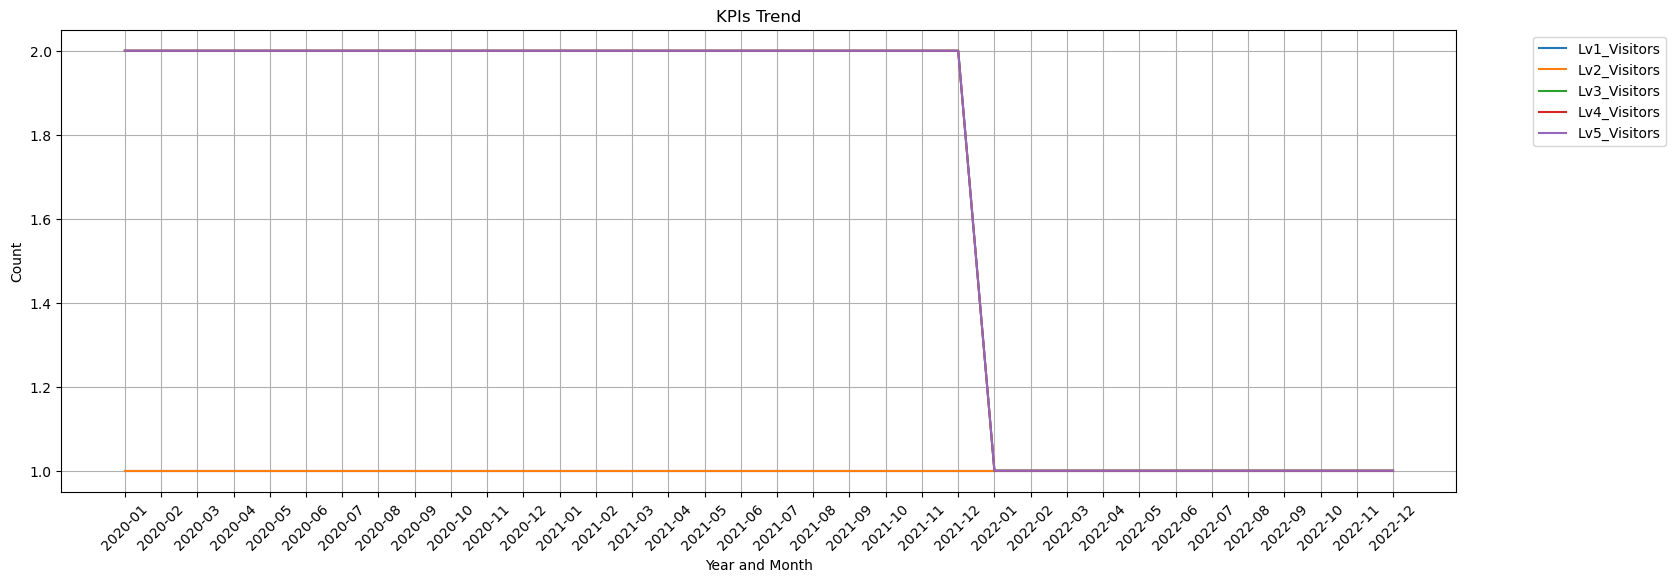

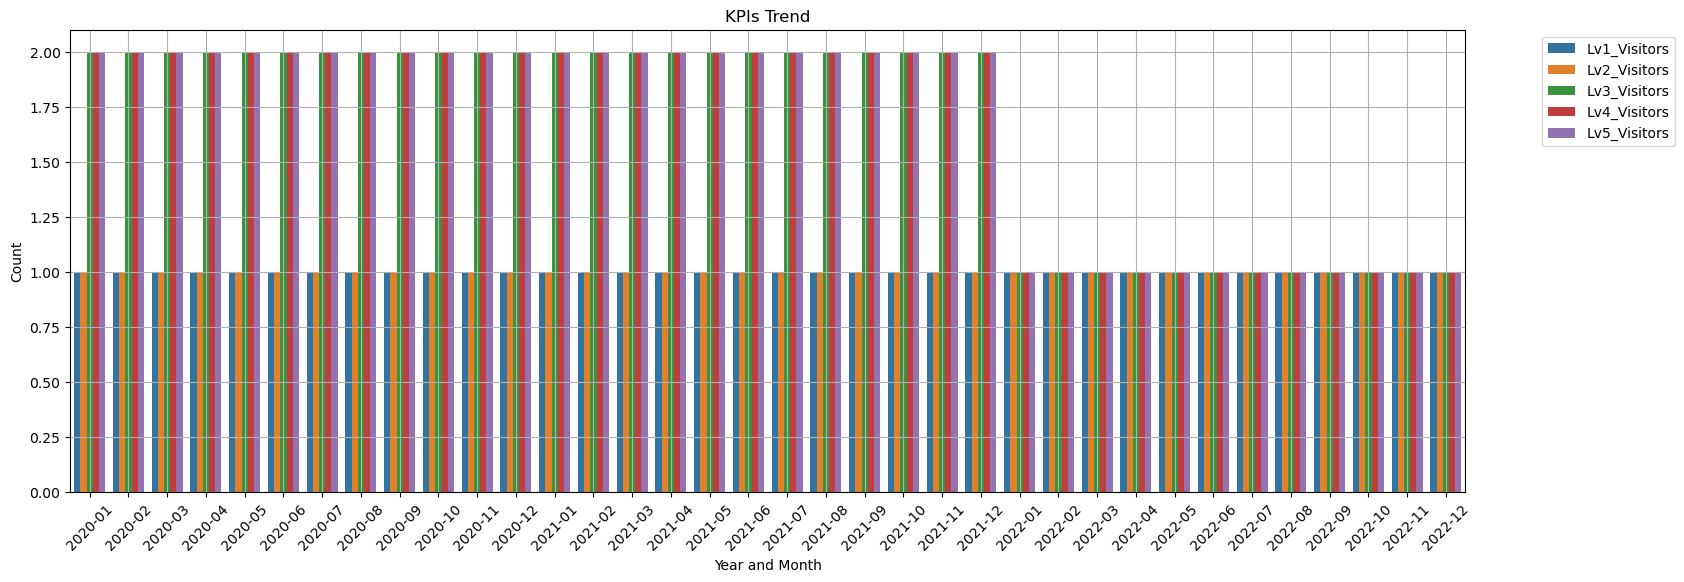

In [74]:
def plot_kpi_trends(data, region, customer_segment, start_year, start_month, end_year, end_month):
    # Filter the data based on the input parameters
    filtered_data = data[(data['Region'] == region) & 
                         (data['Customer Segment'] == customer_segment) & 
                         (data['Year'] >= start_year) & 
                         (data['Year'] <= end_year) & 
                         (data['Month'] >= start_month) & 
                         (data['Month'] <= end_month)]
    
    # Create a new column for year and month
    filtered_data['YearMonth'] = pd.to_datetime(filtered_data[['Year', 'Month']].assign(day=1))
    
    # Convert 'YearMonth' to string type
    filtered_data['YearMonth'] = filtered_data['YearMonth'].dt.strftime('%Y-%m')
    
    # Aggregate the data by 'YearMonth' and 'KPI'
    aggregated_data = filtered_data.groupby(['YearMonth', 'KPI']).size().reset_index(name='Count')

    # Sort 'YearMonth'
    aggregated_data.sort_values('YearMonth', inplace=True)

    # Determine figure size
    num_dates = aggregated_data['YearMonth'].nunique()
    fig_width = max(10, num_dates // 2)

    # Plot line graph
    plt.figure(figsize=(fig_width, 6))
    sns.lineplot(x='YearMonth', y='Count', hue='KPI', data=aggregated_data)
    plt.title('KPIs Trend')
    plt.xlabel('Year and Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Plot bar graph
    plt.figure(figsize=(fig_width, 6))
    sns.barplot(x='YearMonth', y='Count', hue='KPI', data=aggregated_data)
    plt.title('KPIs Trend')
    plt.xlabel('Year and Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Call the function with your parameters
plot_kpi_trends(funnel, 'India', 'Clients', 2020, 1, 2022, 12)

In [75]:
# Initialize label encoders
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()

# Fit and transform 'Customer Segment' and 'Region' columns
funnel['Customer Segment'] = le1.fit_transform(funnel['Customer Segment'])
funnel['Region'] = le2.fit_transform(funnel['Region'])
funnel['KPI'] = le3.fit_transform(funnel['KPI'])

In [76]:
# Assuming 'funnel' is your DataFrame
data = funnel['Value']

# Determine the length of the training data set (80% of total data)
train_len = int(len(data) * 0.8)

# Split the data into training and testing sets
train_data = data[:train_len]
test_data = data[train_len:]

In [77]:
already_done=True
if not already_done:    
    # Define the grid
    param_grid = {'p': list(range(0, 5)), 'd': list(range(0, 3)), 'q': list(range(0, 5)),
                'P': list(range(0, 3)), 'D': list(range(0, 2)), 'Q': list(range(0, 3)), 'm': [1,6,12]}


    # Number of iterations for random search
    n_iter = 100

    best_score, best_params = float("inf"), None

    # Random search
    for i in range(n_iter):
        params = {k: sample(v, 1)[0] for k, v in param_grid.items()}
        try:
            # Train and evaluate SARIMA model
            model = SARIMAX(train_data, order=(params['p'], params['d'], params['q']),
                            seasonal_order=(params['P'], params['D'], params['Q'], params['m']))
            model_fit = model.fit(disp=False)
            mse = mean_squared_error(test_data, model_fit.predict(len(train_data), len(data)-1))
            
            # Update best score and parameters
            if mse < best_score:
                best_score, best_params = mse, params
                
        except:
            continue
        
        print(f"Iteration {i+1}: Best MSE: {best_score}, Best Params: {best_params}")

    print('Best MSE: ', best_score)
    print('Best Parameters: ', best_params)


In [78]:
# Fit the SARIMAX model on the training data
model = SARIMAX(train_data, order=(0, 0, 4), seasonal_order=(2, 1, 2, 6)) #Best Params
model_fit = model.fit(disp=True)

# Make predictions for the length of the test data
forecast = model_fit.predict(len(train_data), len(data)-1)

# Calculate MSE
mse = mean_squared_error(test_data, forecast)

# Calculate RMSE
rmse = mse**0.5

print('MSE: ', mse)
print('RMSE: ', rmse)

MSE:  49251255396.55729
RMSE:  221926.23863923186


In [79]:
# Assuming 'funnel' is your DataFrame
data = funnel['Value']

# Fit the SARIMAX model on the entire data
model = SARIMAX(data, order=(0, 0, 4), seasonal_order=( 2, 1, 2, 6)) #Best Params
model_fit = model.fit(disp=True)

# Make predictions for the entire data
forecast = model_fit.predict(start=0, end=len(data)-1)

# Save the actual and forecasted values to a CSV file
df = pd.DataFrame({
    'Actual': data,
    'Forecast': forecast})
df.to_csv('sarima_forecast.csv', index=False)

mean_squared_error(data, forecast)**0.5

514006.1880220184

In [80]:
# Define a function to evaluate a SARIMA model
def evaluate_sarima_model(data):
    order = (0, 0, 4)
    seasonal_order = ( 2, 1, 2, 6)
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.predict(len(data), len(data)+len(test_data)-1)
    mse = mean_squared_error(test_data, forecast)
    return mse


# Evaluate the original model
original_mse = evaluate_sarima_model(train_data)
print(f'Original MSE: {original_mse}')

# Apply transformations and steps

# 1. Detrending/Stationarity: Apply differencing to make the data stationary
diff_train_data = train_data.diff().dropna()
diff_mse = evaluate_sarima_model(diff_train_data)
print(f'Differenced MSE: {diff_mse}')

# 2. Anomaly detection: Remove outliers
trimmed_train_data = train_data[train_data.between(train_data.quantile(.15), train_data.quantile(.85))]
trimmed_mse = evaluate_sarima_model(trimmed_train_data)
print(f'Trimmed MSE: {trimmed_mse}')

# 3. Missing data: Fill missing values with the mean
filled_train_data = train_data.fillna(train_data.mean())
filled_mse = evaluate_sarima_model(filled_train_data)
print(f'Filled MSE: {filled_mse}')

def evaluate_sarima_model(data, exog_data):
    order = (0, 0, 4)
    seasonal_order = (2, 1, 2, 6)
    model = SARIMAX(data, exog=exog_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.predict(len(data), len(data)+len(test_data)-1, exog=exog_test_data)
    mse = mean_squared_error(test_data, forecast)
    return mse


# Define your exogenous variables based on their correlation with 'Value'
exog_train_data = funnel[:train_len][['Customer Segment', 'Region']]
exog_test_data = funnel[train_len:][['Customer Segment', 'Region']]

# Evaluate the SARIMA model with exogenous variables
exog_mse = evaluate_sarima_model(funnel[:train_len]['Value'], exog_train_data)
print(f'Exogenous MSE: {exog_mse}')

Original MSE: 49251255396.55729
Differenced MSE: 59214282236.928734
Trimmed MSE: 49889326844.751236
Filled MSE: 49251255396.55729
Exogenous MSE: 68315006465.134125


In [81]:
result = adfuller(funnel["Value"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.045752
p-value: 0.001189


MSE: 30716014500.44671
RMSE: 175259.84851199292


Text(0.5, 1.0, 'Autocorrelations of residuals')

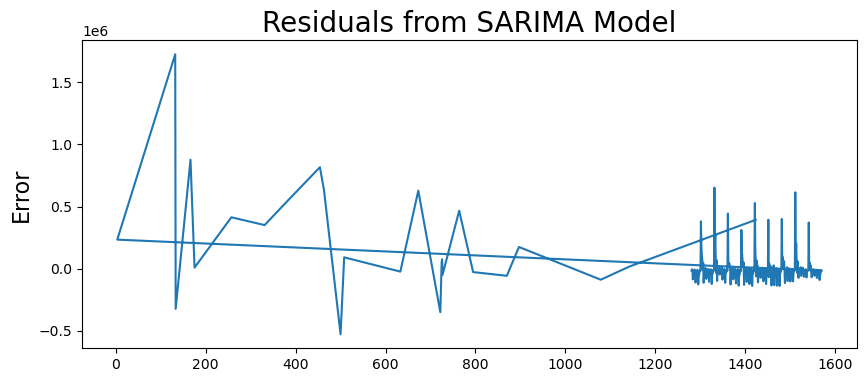

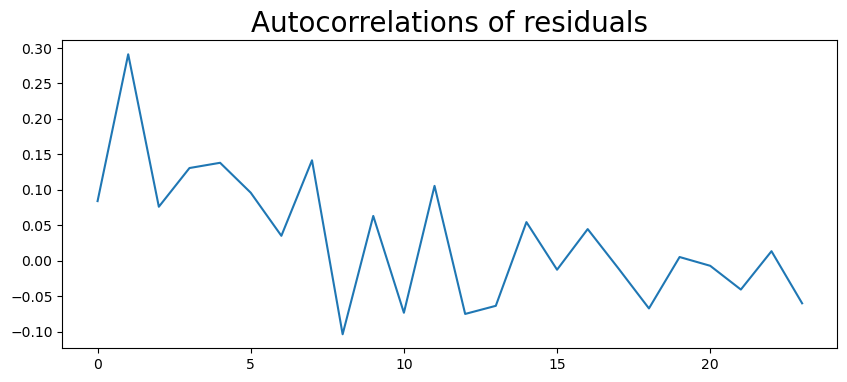

In [82]:
# Fit the model
model_fit = model.fit(disp=False)

# Get the forecast
forecast = model_fit.predict(len(train_data), len(train_data)+len(test_data)-1)

# Calculate residuals
residuals = test_data - forecast

# Print MSE and RMSE
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

# Plot ACF of residuals
acf_values = acf(residuals)
plt.figure(figsize=(10,4))
plt.plot(acf_values[1:])
plt.title('Autocorrelations of residuals', fontsize=20)
